In [6]:
ORS_API_KEY = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjQ2OTY5ZWQ1ODRiZjRhZTViYTIxYWRiYzQ4MDNkMDA5IiwiaCI6Im11cm11cjY0In0="

In [5]:
# Setup cell
import math
import requests
import time
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

# ---- CONFIG ----
ORS_API_KEY = ""  # <-- paste your ORS API key here (optional). If empty, haversine fallback will be used.

# DP discretization
BATTERY_STEP_KWH = 1.0  # discretization step for battery levels (1 kWh resolution). Increase to speed up, decrease to get finer results.

# Safety / defaults
DEFAULT_SPEED_KMPH = 80.0  # average driving speed for time estimates
CHARGER_EFFICIENCY = 0.95  # fraction stored from charger energy


In [7]:
# Helpers for distances and times

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def ors_route_distance_m(coord1, coord2, api_key):
    """
    coord: (lat, lon)
    Returns road distance in meters using ORS directions (driving-car).
    """
    if not api_key:
        raise ValueError("ORS API key required for real road distance.")
    url = "https://api.openrouteservice.org/v2/directions/driving-car"
    headers = {"Authorization": api_key, "Content-Type": "application/json"}
    body = {
        "coordinates": [[coord1[1], coord1[0]], [coord2[1], coord2[0]]],  # ORS expects [lon, lat]
        "units": "m"
    }
    r = requests.post(url, json=body, headers=headers, timeout=20)
    r.raise_for_status()
    data = r.json()
    # distance in meters
    return float(data["features"][0]["properties"]["segments"][0]["distance"])

def distance_km(coord1, coord2, api_key=None):
    """
    Returns distance in kilometers. Uses ORS if key provided, else haversine.
    Wrapped to catch ORS errors and fallback to haversine automatically.
    """
    try:
        if api_key:
            m = ors_route_distance_m(coord1, coord2, api_key)
            return m / 1000.0
    except Exception as e:
        print("ORS request failed, falling back to haversine. Error:", str(e))
    # fallback
    return haversine_km(coord1[0], coord1[1], coord2[0], coord2[1])

def drive_time_hours(dist_km, avg_speed_kmph=DEFAULT_SPEED_KMPH):
    return dist_km / avg_speed_kmph


In [8]:
# We'll treat nodes as: Start + POIs + Destination. Use coords for each node.
# Example format you will provide later: pois_coords = [(lat, lon), ...], chargers_coords = [(lat, lon, power_kw, name), ...]

def build_nodes(start_coord, poi_coords, dest_coord):
    # nodes order: start, poi1, poi2, ..., dest
    nodes = [start_coord] + poi_coords + [dest_coord]
    return nodes

def build_distance_matrix(nodes, api_key=None, sleep_between_calls=1.0):
    # nodes: list of (lat, lon)
    n = len(nodes)
    dist = [[0.0]*n for _ in range(n)]
    # We only need pairwise sequential distances for this linear route, but compute full matrix for flexibility.
    for i in range(n):
        for j in range(i+1, n):
            d = distance_km(nodes[i], nodes[j], api_key)
            dist[i][j] = d
            dist[j][i] = d
            # be polite to ORS free tier
            if api_key:
                time.sleep(sleep_between_calls)
    return dist


In [9]:
# DP optimizer explanation (simple):
# - We discretize battery into integer kWh levels.
# - DP state: dp[i][e] = best (score, time, path, charges) to reach node i with e kWh remaining.
# - Transitions: from dp[i][e], try to go to node j = i+1 (next POI or dest)
#    - If e >= energy_needed -> go without charging.
#    - Else consider charging at any charger between nodes i and j (inclusive) that is reachable from i with current e.
# - This is exponential in chargers choices but manageable for small numbers.

def energy_for_distance(distance_km, consumption_kwh_per_km):
    return distance_km * consumption_kwh_per_km

def find_chargers_between(chargers, coord_i_km, coord_j_km, nodes_coords_km):
    # chargers: list of (km_pos, power_kw, name)
    # Since we have linear route, we compare km positions directly.
    low = min(coord_i_km, coord_j_km)
    high = max(coord_i_km, coord_j_km)
    return [c for c in chargers if (c[0] > low and c[0] <= high)]

def dp_optimize(nodes_coords, dist_matrix, pois_info, chargers_info,
                battery_kwh=60.0, consumption_kwh_per_km=0.15,
                reserve_kwh=6.0, target_soc_kwh=None, charger_eff=CHARGER_EFFICIENCY,
                step_kwh=BATTERY_STEP_KWH, avg_speed_kmph=DEFAULT_SPEED_KMPH):
    """
    nodes_coords: list of coords for nodes (start + pois + dest)
    dist_matrix: precomputed matrix in km
    pois_info: list of dicts, matching nodes indices (start has None), e.g. {'name', 'dwell_min', 'score'}
    chargers_info: list of (km_pos, power_kw, name) — km_pos is distance from start along route (we compute this)
    Returns best plan (greedy recorded inside DP)
    """
    n = len(nodes_coords)
    # compute linear distance from start to each node along the route (accumulated)
    # For linear ordered nodes, cumulative distances are simply sum of consecutive distances
    cum_km = [0.0]*n
    for i in range(1, n):
        cum_km[i] = cum_km[i-1] + dist_matrix[i-1][i]

    # energy per segment from i to i+1
    seg_energy = [energy_for_distance(dist_matrix[i][i+1], consumption_kwh_per_km) for i in range(n-1)]

    # DP table: at node i, for energy level e_kwh (discretized int), store best tuple
    max_kwh = int(round(battery_kwh))
    levels = list(range(0, max_kwh+1, int(round(step_kwh))))
    inf = float('inf')

    # Initialize dp for node 0 (start) with full battery
    dp = [defaultdict(lambda: (-inf, inf, [], [])) for _ in range(n)]
    # value stored: (score, time_h, visited_pois_list_of_indices, charges_list)
    # charges_list: list of dicts {km, name, kwh_added, time_h}

    start_energy_level = int(round(battery_kwh))
    dp[0][start_energy_level] = (0.0, 0.0, [], [])

    # Iterate nodes sequentially
    for i in range(n-1):
        for e_level, state in list(dp[i].items()):
            curr_score, curr_time, curr_path, curr_charges = state
            # Option 1: try to go directly to next node (i+1) without charging
            energy_needed = seg_energy[i]
            if e_level - energy_needed >= reserve_kwh - 1e-9:  # allow tiny tolerance
                new_e = int(round(e_level - energy_needed))
                # if next node is a POI (not start/dest) and has score/dwell
                add_score = 0.0
                add_time = drive_time_hours(dist_matrix[i][i+1], avg_speed_kmph)
                new_path = curr_path.copy()
                extra_charges = curr_charges.copy()
                # POI index corresponds to node index; 0 is start, last is dest
                poi_idx = i+1
                if 0 < poi_idx < n-1:
                    poi = pois_info[poi_idx-1]  # pois_info is for POIs only
                    add_score += poi.get('score', 0.0)
                    add_time += poi.get('dwell_min', 0)/60.0
                    new_path = curr_path + [poi_idx]
                new_state = (curr_score + add_score, curr_time + add_time, new_path, extra_charges)
                # store in dp[i+1] if better by score or same score but less time
                existing = dp[i+1].get(new_e, (-inf, inf, [], []))
                if new_state[0] > existing[0] or (abs(new_state[0]-existing[0])<1e-6 and new_state[1] < existing[1]):
                    dp[i+1][new_e] = new_state

            # Option 2: consider charging at chargers reachable before next node, then go
            # Identify chargers located between cum_km[i] and cum_km[i+1] (or nearby)
            # Also consider chargers located ahead (farthest reachable) to allow planning
            # For simplicity, consider chargers across entire future route up to next few nodes.
            for charger in chargers_info:
                charger_km, charger_power, charger_name = charger
                # compute distance from current node to charger
                dist_to_charger = abs(charger_km - cum_km[i])
                energy_to_charger = energy_for_distance(dist_to_charger, consumption_kwh_per_km)
                if e_level - energy_to_charger < reserve_kwh - 1e-9:
                    continue  # cannot reach this charger from current energy level

                # simulate driving to charger: time and remaining energy
                e_after_reach = e_level - energy_to_charger
                drive_time_to_charger = drive_time_hours(dist_to_charger, avg_speed_kmph)

                # choose discrete charging target levels (we'll try a few: target_kwh steps up to battery)
                # convert target to kWh values
                for target_kwh in range(int(math.ceil(reserve_kwh)), int(round(battery_kwh))+1, int(round(step_kwh))):
                    if target_kwh <= e_after_reach:
                        continue  # already at or above this target
                    kwh_needed_raw = (target_kwh - e_after_reach)
                    kwh_from_grid = kwh_needed_raw / charger_eff  # account for efficiency
                    charge_time = charge_time_hours(kwh_from_grid, charger_power)
                    # after charging, remaining energy is increased by stored energy
                    e_after_charge = min(battery_kwh, e_after_reach + kwh_from_grid * charger_eff)
                    # now try to go to next node (i+1) from charger
                    # compute distance charger -> node i+1
                    dist_charger_to_nextnode = abs(cum_km[i+1] - charger_km)
                    energy_to_next = energy_for_distance(dist_charger_to_nextnode, consumption_kwh_per_km)
                    if e_after_charge - energy_to_next < reserve_kwh - 1e-9:
                        continue  # even after charging we can't reach next node
                    # simulate driving to next node
                    new_e = int(round(e_after_charge - energy_to_next))
                    # time summation: drive_to_charger + charge_time + drive_charger->nextnode
                    time_add = drive_time_to_charger + charge_time + drive_time_hours(dist_charger_to_nextnode, avg_speed_kmph)
                    new_path = curr_path.copy()
                    extra_charges = curr_charges.copy()
                    # if the next node is a POI, add its score/time
                    add_score = 0.0
                    add_time = 0.0
                    poi_idx = i+1
                    if 0 < poi_idx < n-1:
                        poi = pois_info[poi_idx-1]
                        add_score += poi.get('score', 0.0)
                        add_time += poi.get('dwell_min', 0)/60.0
                        new_path = curr_path + [poi_idx]
                    # new state
                    new_state = (curr_score + add_score, curr_time + time_add + add_time,
                                 new_path, extra_charges + [{
                                     'km': charger_km,
                                     'name': charger_name,
                                     'kwh_added': round(kwh_needed_raw,3),
                                     'charge_time_h': round(charge_time,3)
                                 }])
                    existing = dp[i+1].get(new_e, (-inf, inf, [], []))
                    if new_state[0] > existing[0] or (abs(new_state[0]-existing[0])<1e-6 and new_state[1] < existing[1]):
                        dp[i+1][new_e] = new_state

    # After DP, check last node (destination) for best state
    best = (-inf, inf, [], [])
    for e_level, state in dp[-1].items():
        if state[0] > best[0] or (abs(state[0]-best[0])<1e-6 and state[1] < best[1]):
            best = state
    best_score, best_time, best_path, best_charges = best
    # Convert best_path (node indices) into POI names and timeline if needed
    return {
        'best_score': best_score,
        'best_time_h': best_time,
        'visited_node_indices': best_path,
        'charges': best_charges,
        'dp_table': dp  # keep for debugging/inspection
    }


In [10]:
# EXAMPLE: provide coordinates (lat, lon)
# Start and destination coords can be the first and last POI if you prefer
start_coord = (28.6139, 77.2090)   # New Delhi (example)
poi_coords = [
    (28.7041, 77.1025),  # example POI 1 (Delhi nearby)
    (29.9457, 78.1642),  # example POI 2 (place further away)
    (30.3200, 78.0667),  # example POI 3
]
dest_coord = (30.7333, 76.7794)  # Chandigarh (example)

# POI info corresponding to poi_coords: name, dwell_min, score (you must have same order)
pois_info = [
    {'name': 'POI A', 'dwell_min': 30, 'score': 5.0},
    {'name': 'POI B', 'dwell_min': 45, 'score': 8.0},
    {'name': 'POI C', 'dwell_min': 40, 'score': 7.0}
]

# Chargers_info: use km positions derived later. For now give approximate km positions or leave empty to skip chargers
# We'll compute km positions from cumulative distances after building dist matrix
chargers_raw = [
    # placeholder: we'll set them after computing cumulative route km
    # (approx_km_from_start, power_kw, name)
]

# Build nodes
nodes = build_nodes(start_coord, poi_coords, dest_coord)
print("Computing distances (this may take time if ORS is used)...")
dist_mat = build_distance_matrix(nodes, api_key=ORS_API_KEY, sleep_between_calls=1.0)
print("Distance matrix (km):")
for row in dist_mat:
    print([round(x,2) for x in row])

# compute cumulative km along the linear route
cum_km = [0.0]
for i in range(1, len(nodes)):
    cum_km.append(cum_km[-1] + dist_mat[i-1][i])
print("Cumulative km along route:", [round(x,2) for x in cum_km])

# Example chargers: choose some along the route using cumulative km
chargers_info = [
    (round(cum_km[1] * 0.9,1), 120.0, "FastCharge Near POI1"),  # around 90% of first segment
    (round(cum_km[2] * 0.8,1), 150.0, "FastCharge Midway"),     # etc.
]
print("Chargers used (approx km):", chargers_info)

# Run DP optimizer
res = dp_optimize(nodes, dist_mat, pois_info, chargers_info,
                  battery_kwh=60.0, consumption_kwh_per_km=0.15,
                  reserve_kwh=6.0, target_soc_kwh=48.0, step_kwh=1.0,
                  avg_speed_kmph=70.0)
print("\nOptimization result:")
print("Best score:", res['best_score'])
print("Best time (h):", res['best_time_h'])
print("Visited nodes indices (node indices):", res['visited_node_indices'])
print("Charges planned:", res['charges'])


Computing distances (this may take time if ORS is used)...
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
ORS request failed, falling back to haversine. Error: 'features'
Distance matrix (km):
[0.0, 14.44, 174.68, 207.08, 239.29]
[14.44, 0.0, 172.2, 202.46, 227.78]
[174.68, 172.2, 0.0, 42.66, 159.15]
[207.08, 202.46, 42.66, 0.0, 131.59]
[239.29, 227.78, 159.15, 131.59, 0.0]
Cumulative km along route: [0.0, 14.44, 186.64, 229.31, 360.89]
Chargers used (approx

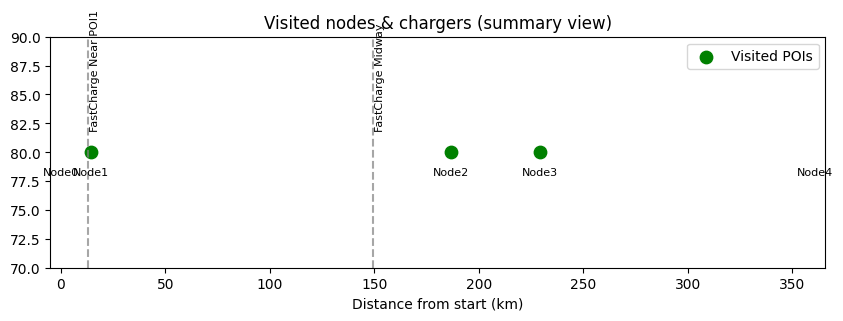

In [11]:
# Build a simple SOC timeline from DP result using the dp_table final path (approximate)
best_path_indices = res['visited_node_indices']
# We can reconstruct a rough timeline by walking nodes and assuming initial battery and charging events
# For simplicity, produce a simple plot: node positions (cum_km) and show which nodes were visited
visited_km = [cum_km[idx] for idx in best_path_indices] if best_path_indices else []
plt.figure(figsize=(10,3))
plt.plot(cum_km, [100]*len(cum_km), alpha=0)  # invisible anchor
plt.scatter(visited_km, [80]*len(visited_km), s=80, color='green', label='Visited POIs')
# Mark chargers
for ch in chargers_info:
    plt.axvline(ch[0], linestyle='--', color='gray', alpha=0.7)
    plt.text(ch[0]+1, 82, ch[2], rotation=90, fontsize=8)
for i, km in enumerate(cum_km):
    plt.text(km, 78, f"Node{i}", fontsize=8, ha='center')
plt.xlim(-5, cum_km[-1]+5)
plt.ylim(70, 90)
plt.xlabel("Distance from start (km)")
plt.title("Visited nodes & chargers (summary view)")
plt.grid(False)
plt.legend()
plt.show()
